# Exploration and visualization of our collected metrics 
In this notebook, we will read the collected metrics from ceph and uses interactive widgets to explore and visualize our data.

In [23]:
# !pip install fsspec s3fs

     |████████████████████████████████| 48 kB 9.7 MB/s  eta 0:00:01
     |████████████████████████████████| 7.4 MB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 56.2 MB/s eta 0:00:01
  Created wheel for aiobotocore: filename=aiobotocore-1.3.0-py3-none-any.whl size=45779 sha256=4b9e31ca5e9447bcb2a14584c11368254260f34d38e96cf21ad86c05c934c6be
  Stored in directory: /tmp/pip-ephem-wheel-cache-afobtx_5/wheels/f3/c8/af/bc69105edc81462cf4bca30d72a792a173f80522042defc6a1
Successfully built aiobotocore
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.47
    Uninstalling botocore-1.20.47:
      Successfully uninstalled botocore-1.20.47
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

In [1]:
import os
import ipywidgets as widgets
from functools import partial

from matplotlib import pyplot as plt
import seaborn as sns

from ipynb.fs.defs.metric_template import CephCommunication

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv(
    "S3_ENDPOINT", "https://s3-openshift-storage.apps.zero.massopen.cloud/"
)
s3_access_key = os.getenv("S3_ACCESS_KEY", "v3FnruQ78kfeULDjejUB")
s3_secret_key = os.getenv("S3_SECRET_KEY", "kJiDiHXncLJOXbaL7Zeb5Ok+gkLt9sWIa1rWAJa0")
s3_bucket = os.getenv("S3_BUCKET", "opf-datacatalog")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION", True)

In [3]:
# ceph connector
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
# FIXME: ideally these should be the ones beginning with the metrics prefix, and not all parquets
# available_metrics = metrics_bucket.objects.filter(Prefix=s3_path)
available_metric_objs = [o for o in metrics_bucket.objects.all() if "parquet" in o.key]

for i in available_metric_objs:
    print(i)

s3.ObjectSummary(bucket_name='opf-datacatalog', key='None/consec_fail_stats_df.parquet')
s3.ObjectSummary(bucket_name='opf-datacatalog', key='None/pct_fixed_per_ts.parquet')
s3.ObjectSummary(bucket_name='opf-datacatalog', key='metrics/flake.parquet')


In [15]:
# extract the names of unique KPI metric files, and the KPIs available in them
kpis_in_metric_objs = dict()
for o in available_metric_objs:
    if o not in kpis_in_metric_objs:
        # read a sample file to see what kpis are contained in this file
        prefix, key = o.key.split("/")
        # FIXME: Ideally prefix will always be "metrics" but rn it isnt so manually set it
        sample_file = cc.read_from_ceph(prefix, key)

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "grid", "test"], errors="ignore"
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_metric_objs[key.split(".")[0]] = kpis

kpis_in_metric_objs

{'consec_fail_stats_df': ['consec_fail_rate',
  'mean_fail_len',
  'mean_time_to_fix',
  'pass_to_fail_rate',
  'fail_to_pass_rate'],
 'pct_fixed_per_ts': ['pct_fixed'],
 'flake': ['test_duration', 'flake']}

In [22]:
# select metric objects and the kpis in them to visualize
def on_metric_obj_selected(metric_obj, kpis_widget=None):
    new_opts = []
    for selected_obj in metric_obj.new:
        new_opts += kpis_in_metric_objs[selected_obj]
    kpis_widget.options = new_opts


metric_obj_widget = widgets.SelectMultiple(
    options=kpis_in_metric_objs.keys(), disabled=False
)

kpis_widget = widgets.SelectMultiple(options=[], disabled=False)

metric_obj_widget.observe(
    partial(on_metric_obj_selected, kpis_widget=kpis_widget),
    "value",
)

display(metric_obj_widget)
display(kpis_widget)

SelectMultiple(options=('consec_fail_stats_df', 'pct_fixed_per_ts', 'flake'), value=())

SelectMultiple(options=(), value=())

In [23]:
metric_obj_widget.value, kpis_widget.value

(('pct_fixed_per_ts', 'flake'), ('pct_fixed', 'flake'))

In [24]:
s3_path, f"{metric_obj_widget.value[1]}.parquet"

('metrics', 'flake.parquet')

## todo
- right now this will fail for some cases because not all metrics are under "metrics" prefix (see https://github.com/aicoe-aiops/ocp-ci-analysis/issues/217#issuecomment-819624029)
- need to know what columns exist in which df when indexing
- some dfs have a column "grid" vs some others have "job"?

In [31]:
# read one of the kpis to plot the selected metrics objects from ceph
metric = cc.read_from_ceph(s3_path, f"{metric_obj_widget.value[1]}.parquet")
metric[["timestamp", "tab", "grid", "test"] + [kpis_widget.value[1]]].head()

,timestamp,tab,grid,test,flake
0,2021-03-15 23:40:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False
1,2021-03-15 00:01:06,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False
2,2021-03-13 20:51:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False
3,2021-03-13 07:51:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False
4,2021-03-13 06:43:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False


## Next step 1

assuming there is a metric df that looks like above, plot something like this:

Given a dashboard (e.g. "redhat-openshift-ocp-release-4.6-informing”), plot the `Overall` KPI values for jobs within the dashboard (e.g. plot the Overall test duration for “periodic-ci-openshift-release-master-ci-4.6-e2e-aws” vs “periodic-ci-openshift-release-master-ci-4.6-e2e-gcp” vs …)

## Next step 2

assuming there is a metric df that looks like above, plot something like this:

Given a job (e.g. “periodic-ci-openshift-release-master-ci-4.6-e2e-gcp”), plot the KPI values for tests within the job (e.g. plot duration for “operator conditions cloud-credential” vs “operator conditions cluster-autoscaler” vs ...)

In [12]:
def plot_builds_tab_grid(tab, job, df, metric_name):

    """
    Takes in input as tab and grid and plots change in
    build pass/fail over time
    """

    df = df[(df["tab"] == tab) | (df["job"] == job)]

    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y=metric_name, data=df)
    plt.xlabel("Timestamps")
    plt.ylabel(metric_name)
    plt.title("Change in Build Pass or Failure over time")
    plt.show()

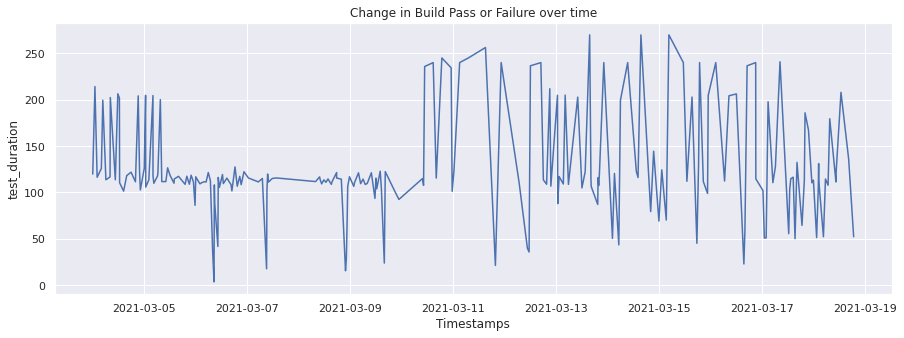

In [13]:
plot_builds_tab_grid(
    "redhat-openshift-informing",
    "release-openshift-okd-installer-e2e-aws-upgrade",
    metric,
    "test_duration",
)

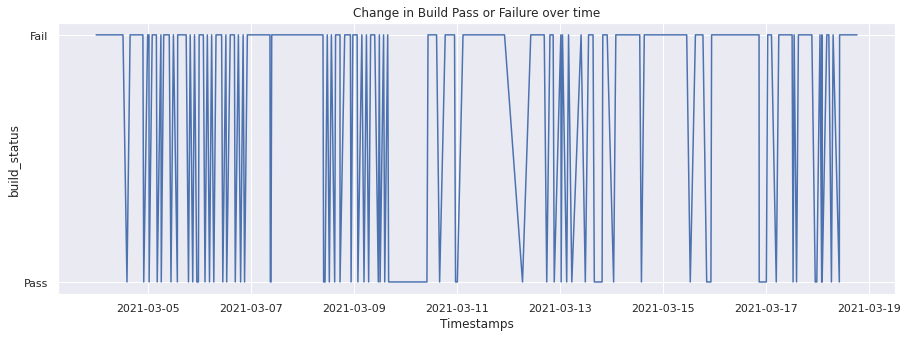

In [14]:
plot_builds_tab_grid(
    "redhat-openshift-informing",
    "release-openshift-okd-installer-e2e-aws-upgrade",
    metric,
    "build_status",
)